In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# load packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/efl1results/E1-2017-2018.csv
/kaggle/input/efl1results/E1-2016-2017.csv
/kaggle/input/efl1results/E1-2015-2016.csv
/kaggle/input/efl1results/E1-2018-2019.csv
/kaggle/input/efl1results/E1-2019-2020.csv


In [2]:
# %% load historical data
xls1 = pd.read_csv(dirname+'/E1-2015-2016.csv')
xls2 = pd.read_csv(dirname+'/E1-2016-2017.csv')
xls3 = pd.read_csv(dirname+'/E1-2017-2018.csv')
xls4 = pd.read_csv(dirname+'/E1-2019-2020.csv')

FullDF = pd.concat([xls1, xls2, xls3, xls4], ignore_index=True)
print('Data loaded')

Data loaded


In [3]:
# %% Drop columns that are not needed
toDrop = ['Div',
'Date',
'HTHG',
'HTAG',
'HTR',
'Referee',
'BWH',
'BWD',
'BWA',
'IWH',
'IWD',
'IWA',
'LBH',
'LBD',
'LBA',
'WHH',
'WHD',
'WHA',
'VCH',
'VCD',
'VCA',
'Bb1X2',
'BbMxH',
'BbAvH',
'BbMxD',
'BbAvD',
'BbMxA',
'BbAvA',
'BbOU',
'BbMx>2.5',
'BbAv>2.5',
'BbMx<2.5',
'BbAv<2.5',
'BbAH',
'BbAHh',
'BbMxAHH',
'BbAvAHH',
'BbMxAHA',
'BbAvAHA',
'PSCH',
'PSCD',
'PSCA',
'Time',
'MaxH',
'MaxD',
'MaxA',
'AvgH',
'AvgD',
'AvgA',
'B365>2.5',
'B365<2.5',
'P>2.5',
'P<2.5',
'Max>2.5',
'Max<2.5',
'Avg>2.5',
'Avg<2.5',
'AHh',
'B365AHH',
'B365AHA',
'PAHH',
'PAHA',
'MaxAHH',
'MaxAHA',
'AvgAHH',
'AvgAHA',
'B365CH',
'B365CD',
'B365CA',
'BWCH',
'BWCD',
'BWCA',
'IWCH',
'IWCD',
'IWCA',
'WHCH',
'WHCD',
'WHCA',
'VCCH',
'VCCD',
'VCCA',
'MaxCH',
'MaxCD',
'MaxCA',
'AvgCH',
'AvgCD',
'AvgCA',
'B365C>2.5',
'B365C<2.5',
'PC>2.5',
'PC<2.5',
'MaxC>2.5',
'MaxC<2.5',
'AvgC>2.5',
'AvgC<2.5',
'AHCh',
'B365CAHH',
'B365CAHA',
'PCAHH',
'PCAHA',
'MaxCAHH',
'MaxCAHA',
'AvgCAHH',
'AvgCAHA']

FullDF = FullDF.drop(toDrop, axis=1)
FullDF = FullDF.dropna()

# %%create home/away win features
FullDF['Hwin'] = FullDF['FTR']=='H'
FullDF['Hwin'] = FullDF['Hwin'].astype(int)
FullDF['Awin'] = FullDF['FTR'] == 'A'
FullDF['Awin'] = FullDF['Awin'].astype(int)

# convert odds to probabilities
FullDF['Hp'] = 1/FullDF['PSH']
FullDF['Dp'] = 1/FullDF['PSD']
FullDF['Ap'] = 1/FullDF['PSA']

book_probs = FullDF[['Hp', 'Dp', 'Ap']]
# book_probs['Hp'] = 1/FullDF['PSH']
# book_probs['Dp'] = 1/FullDF['PSD']
# book_probs['Ap'] = 1/FullDF['PSA']

# TODO: should add odds normalisation here
# drop odds
FullDF = FullDF.drop(['B365H', 'B365D', 'B365A', 'PSH', 'PSD', 'PSA'], axis=1)

In [4]:
# features net goals, shots
FullDF['GDH'] = FullDF['FTHG'] - FullDF['FTAG']
FullDF['GDA'] = FullDF['FTAG'] - FullDF['FTHG']
FullDF['SDH'] = FullDF['HS'] - FullDF['AS']
FullDF['SDA'] = FullDF['AS'] - FullDF['HS']
FullDF['STDH'] = FullDF['HST'] - FullDF['AST']
FullDF['STDA'] = FullDF['AST'] - FullDF['HST']

rllAvgDF = FullDF[['HomeTeam', 'AwayTeam']].copy()
# decided to drop draw for averaging
# forAvg = ['FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC',
# 'HY', 'AY', 'HR', 'AR', 'B365Hp', 'B365Ap', 'PSHp', 'PSAp',]
forAvg = ['FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC',
 'HY', 'AY', 'HR', 'AR']
rllAvgDF[forAvg] = 0

teamList = rllAvgDF['HomeTeam'].unique()

# homeFeats = ['Hwin', 'FTHG', 'HS', 'HST', 'HF',  'HC', 'HY', 'HR', 'B365Hp', 
#              'PSHp', 'GDH', 'SDH','STDH']
# awayFeats = ['Awin', 'FTAG', 'AS', 'AST', 'AF', 'AC', 'AY', 'AR',  'B365Ap', 
#              'PSAp', 'GDA', 'SDA', 'STDA']
homeFeats = ['Hwin', 'FTHG', 'HS', 'HST', 'HF',  'HC', 'HY', 'HR', 'GDH', 'SDH','STDH']
awayFeats = ['Awin', 'FTAG', 'AS', 'AST', 'AF', 'AC', 'AY', 'AR', 'GDA', 'SDA', 'STDA']

winLen = 15
for team in teamList:
    homeSlc = FullDF[FullDF['HomeTeam']==team]
    rllAvgDF.loc[rllAvgDF['HomeTeam']==team, homeFeats] = \
        homeSlc[homeFeats].shift(1).rolling(winLen, min_periods=1).mean()
    awaySlc = FullDF[FullDF['AwayTeam']==team]
    rllAvgDF.loc[rllAvgDF['AwayTeam']==team, awayFeats] = \
        awaySlc[awayFeats].shift(1).rolling(winLen, min_periods=1).mean()

print('Rolling averages calculated...')

rllAvgDF[['Hp', 'Dp', 'Ap']] = FullDF[['Hp', 'Dp', 'Ap']]

# features predicted goal difference
rllAvgDF['GD'] = rllAvgDF['GDH'] - rllAvgDF['GDA']
rllAvgDF['SD'] = rllAvgDF['SDH'] - rllAvgDF['SDA']
rllAvgDF['STD'] = rllAvgDF['STDH'] - rllAvgDF['STDA']
rllAvgDF['WD'] = rllAvgDF['Hwin'] - rllAvgDF['Awin']
rllAvgDF.tail()

Rolling averages calculated...


,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HF,AF,...,GDA,SDA,STDA,Hp,Dp,Ap,GD,SD,STD,WD
2203,Nott'm Forest,Stoke,1.133333,1.133333,14.000000,9.666667,3.533333,3.266667,11.933333,12.333333,...,-0.800000,-2.266667,-1.533333,0.456621,0.301205,0.282486,0.733333,5.800000,1.933333,0.200000
2204,Reading,Swansea,1.066667,1.466667,11.666667,11.533333,3.533333,3.400000,11.400000,10.733333,...,-0.200000,-3.733333,-0.666667,0.258398,0.269542,0.510204,0.066667,0.400000,-0.800000,0.066667
2205,Sheffield Weds,Middlesbrough,0.733333,1.333333,14.800000,10.866667,3.866667,3.466667,13.600000,14.066667,...,0.000000,-1.733333,-1.200000,0.421941,0.308642,0.308642,-0.933333,6.666667,1.600000,-0.200000
2206,West Brom,QPR,1.666667,0.933333,15.400000,10.133333,5.666667,3.466667,12.200000,13.666667,...,-0.400000,-2.666667,-0.666667,0.806452,0.160514,0.078493,1.200000,8.533333,3.800000,0.266667
2207,Wigan,Fulham,1.600000,1.000000,12.333333,11.800000,4.533333,3.800000,12.266667,12.266667,...,0.066667,-0.400000,-0.400000,0.389105,0.268817,0.383142,0.466667,3.866667,2.000000,0.000000


In [5]:
# Test train split
# Take first 70% for training
validDF = rllAvgDF.iloc[24:, :]
validDF = validDF.drop(['HomeTeam', 'AwayTeam'], axis=1)
validDF = validDF.dropna()

Ntrain = round(0.7*validDF.shape[0])
Ntest = validDF.shape[0] - Ntrain

X_train = validDF.head(Ntrain)
X_test = validDF.tail(Ntest)


<BarContainer object of 29 artists>

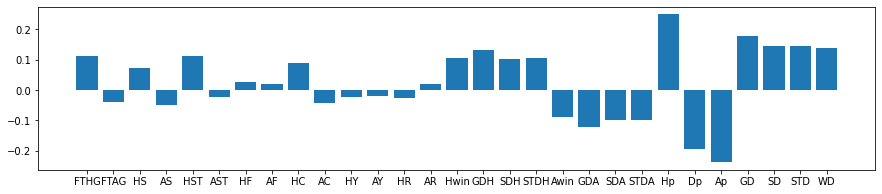

In [6]:
# %% Home goals model
HG = FullDF.iloc[24:, 2]
HG_train = HG.head(Ntrain)
HG_test = HG.tail(Ntest)

corrResults = X_train.corrwith(HG_train)
plt.subplots(figsize=(15, 3))
plt.bar(X_train.columns, corrResults)

Gradient boosted regressor
Training MSE:  1.333215498247148
Test MSE:  1.485661951863681


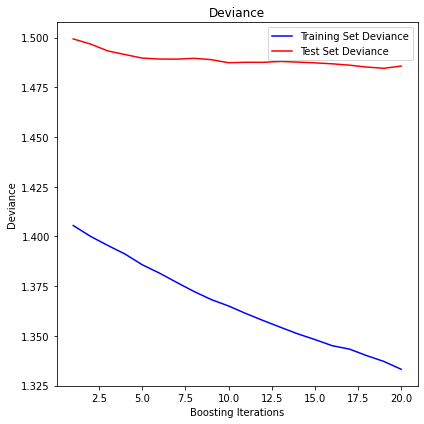

alpha parameter = 0.001
LASSO, Ridge and linear regression
Training MSE:  1.378318389756367 1.3752990593322845
Test MSE:  1.4748132522357091 1.4748132522357091
alpha parameter = 0.01
LASSO, Ridge and linear regression
Training MSE:  1.4003739872502396 1.3755021421349052
Test MSE:  1.4716339147427209 1.4716339147427209
alpha parameter = 0.1
LASSO, Ridge and linear regression
Training MSE:  1.4118946537432568 1.3756445722822737
Test MSE:  1.4703767067639115 1.4703767067639115
alpha parameter = 1
LASSO, Ridge and linear regression
Training MSE:  1.4118946537432568 1.377349611537163
Test MSE:  1.4685071759300732 1.4685071759300732
alpha parameter = 10
LASSO, Ridge and linear regression
Training MSE:  1.4118946537432568 1.3824860688973144
Test MSE:  1.47427238249918 1.47427238249918
alpha parameter = 100
LASSO, Ridge and linear regression
Training MSE:  1.4118946537432568 1.3918568712706187
Test MSE:  1.4859534283590417 1.4859534283590417
alpha parameter = 1000.0
LASSO, Ridge and linear reg

Lasso(alpha=0.001)

In [7]:

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE
# %%
HG_GBR_mdl = GradientBoostingRegressor(n_estimators=20, learning_rate=0.08,
                                  max_depth=2, random_state=0)
HG_GBR_mdl.fit(X_train, HG_train)

print('Gradient boosted regressor')
print('Training MSE: ', MSE(HG_GBR_mdl.predict(X_train), HG_train))
print('Test MSE: ', MSE(HG_GBR_mdl.predict(X_test), HG_test))

# %% Visulise training loss
params = {"n_estimators": 20}
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, HG_pred in enumerate(HG_GBR_mdl.staged_predict(X_test)):
    test_score[i] = HG_GBR_mdl.loss_(HG_test, HG_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    HG_GBR_mdl.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

# %% LASSO regression
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
alpGrid = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3]
tstLossLASSO = []
tstLossRidge = []
#X_train = scl.fit_transform(X_train)
#X_test = scl.fit_transform(X_test)

for i in alpGrid:
    HG_ridge = linear_model.Ridge(alpha=i)
    HG_lasso = linear_model.Lasso(alpha=i)
    HG_ridge.fit(X_train, HG_train)
    HG_lasso.fit(X_train, HG_train)
    print('alpha parameter =', i)
    print('LASSO, Ridge and linear regression')
    print('Training MSE: ', MSE(HG_lasso.predict(X_train), HG_train), MSE(HG_ridge.predict(X_train), HG_train))
    print('Test MSE: ', MSE(HG_ridge.predict(X_test), HG_test), MSE(HG_ridge.predict(X_test), HG_test))
    tstLossLASSO.append(MSE(HG_lasso.predict(X_test), HG_test))
    tstLossRidge.append(MSE(HG_ridge.predict(X_test), HG_test))
HG_linear = linear_model.LinearRegression()
HG_linear.fit(X_train, HG_train)
print('Test MSE: ', MSE(HG_linear.predict(X_test), HG_test))      
HG_lasso = linear_model.Lasso(alpha=alpGrid[np.argmin(tstLossLASSO)])
HG_ridge = linear_model.Ridge(alpha=alpGrid[np.argmin(tstLossRidge)])
HG_ridge.fit(X_train, HG_train)
HG_lasso.fit(X_train, HG_train)

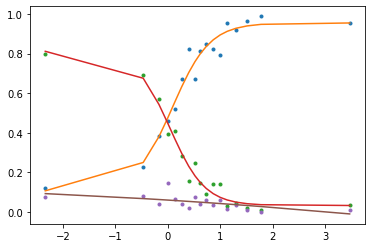

In [8]:
# %% Rating model based on trailing goal difference
from scipy.optimize import curve_fit
from scipy.special import expit
GD_DF = X_train.copy()
nBins = 17
GD_DF['bin'] = pd.qcut(X_train['GD'], nBins, duplicates='drop')
GD_DF['Hwin'] = 0;
GD_DF.loc[GD_DF['FTHG']>GD_DF['FTAG'], 'Hwin'] = 1

sigmoid = lambda x, a, b, c, d : a*expit(b*x-c)+d

binList = sorted(GD_DF['bin'].unique())
binVals = np.empty([nBins, 1])
winPer = np.empty([nBins, 1])
for i, b in enumerate(binList):
    members = GD_DF.loc[GD_DF['bin']==b, 'Hwin']
    binVals[i] = b.mid
    winPer[i] = (members==1).sum()/len(members)
    #print(b.mid, sum(GD_DF.loc[(GD_DF['bin']==b)&(GD_DF['Hwin']==1), 'Hwin']))
    
popt, pcov = curve_fit(sigmoid, binVals[:, 0], winPer[:, 0], [1, 1, 0, 0.1])
homeSig = lambda x: sigmoid(x, popt[0],  popt[1],  popt[2],  popt[3])  
plt.plot(binVals, winPer, '.', binVals, homeSig(binVals))

GD_DF['Awin'] = 0;
GD_DF.loc[GD_DF['FTHG']<GD_DF['FTAG'], 'Awin'] = 1

binVals = np.empty([nBins, 1])
winPer = np.empty([nBins, 1])
for i, b in enumerate(binList):
    members = GD_DF.loc[GD_DF['bin']==b, 'Awin']
    binVals[i] = b.mid
    winPer[i] = (members==1).sum()/len(members)
    #print(b.mid, sum(GD_DF.loc[(GD_DF['bin']==b)&(GD_DF['Hwin']==1), 'Hwin']))
    
poptA, pcovA = curve_fit(sigmoid, binVals[:, 0], winPer[:, 0], [-1, 1, 0, 0.1])
awaySig = lambda x: sigmoid(x, poptA[0],  poptA[1],  poptA[2],  poptA[3])  
plt.plot(binVals, winPer, '.', binVals, awaySig(binVals))

GD_DF['draw'] = 0;
GD_DF.loc[GD_DF['FTHG']==GD_DF['FTAG'], 'draw'] = 1

binVals = np.empty([nBins, 1])
winPer = np.empty([nBins, 1])
for i, b in enumerate(binList):
    members = GD_DF.loc[GD_DF['bin']==b, 'draw']
    binVals[i] = b.mid
    winPer[i] = (members==1).sum()/len(members)
    #print(b.mid, sum(GD_DF.loc[(GD_DF['bin']==b)&(GD_DF['Hwin']==1), 'Hwin']))

draw_p = np.polyfit(binVals[:, 0], winPer[:, 0], 2)
plt.plot(binVals[:, 0], winPer[:, 0], '.', binVals, np.polyval(draw_p, binVals))


In [9]:
# %% away goals model
AG = FullDF.iloc[24:, 3]
AG_train = AG.head(Ntrain)
AG_test = AG.tail(Ntest)
# fit lasso model
AG_clf = linear_model.Ridge(alpha=0.001)
AG_clf.fit(X_train, AG_train)
print('LASSO regression')
print('Training MSE: ', MSE(AG_clf.predict(X_train), AG_train))
print('Test MSE: ', MSE(AG_clf.predict(X_test), AG_test))

# Create a function that approximates match outcome probabilities using a 
# bi-variate Poisson distribution
import scipy as sp
preds = pd.DataFrame(index=X_train.index)
preds['xHG'] = HG_ridge.predict(X_train)
preds['xAG'] = AG_clf.predict(X_train)
preds[['Hp', 'Dp', 'Ap']] = book_probs[['Hp', 'Dp', 'Ap']]
def matchPredict(series):
    goalsHome = series['xHG']
    goalsAway = series['xAG']
    poissProb = np.empty([10, 10])
    for i in range(10):
        for j in range(10):
            poissProb[i,j] = sp.stats.poisson.pmf(i, goalsHome)*sp.stats.poisson.pmf(j, goalsAway)
    homeProb = np.sum(np.tril(poissProb, -1))
    awayProb = np.sum(np.triu(poissProb, 1))
    drawProb = np.sum(np.identity(10)*poissProb)
    return homeProb, drawProb, awayProb
print('Making predictions...')
preds_prob = preds.apply(matchPredict, axis=1, result_type='expand')
preds[['HomePred', 'DrawPred', 'AwayPred']] = preds_prob

def matchPredict_fit(series):
    rating = series['GD']
    homeProb = homeSig(rating)
    awayProb = awaySig(rating)
    drawProb = np.polyval(draw_p, rating)
    return homeProb, drawProb, awayProb
print('Making predictions...')
preds['GD'] = X_train['GD']
preds_prob_fit = preds.apply(matchPredict_fit, axis=1, result_type='expand')
preds[['GD_H_Pred', 'GD_D_Pred', 'GD_A_Pred']] = preds_prob_fit

# %% calculate result from prediction
preds['FTHG'] = HG_train
preds['FTAG'] = AG_train

# function for converting probabilities to predictions
def probs_to_result(series, probs):
    H = series[probs[0]]
    D = series[probs[1]]
    A = series[probs[2]]
    if (H>D) and (H>A):
        outcome = 'H'
    elif (A>H) and (A>D):
        outcome = 'A'
    else:
        outcome = 'D'
    return outcome
preds['rslt'] = 'D'
preds.loc[preds['FTHG']>preds['FTAG'], 'rslt'] = 'H' 
preds.loc[preds['FTAG']>preds['FTHG'], 'rslt'] = 'A'

preds['gd_mdl'] = preds.apply(probs_to_result, axis=1, args=[['GD_H_Pred', 'GD_D_Pred', 'GD_A_Pred']])
preds['bookies'] = preds.apply(probs_to_result, axis=1, args=[['Hp', 'Dp', 'Ap']])
preds['model'] = preds.apply(probs_to_result, axis=1, args=[['HomePred', 'DrawPred', 'AwayPred']])

print(sum(preds['rslt']==preds['bookies'])/len(preds))
print(sum(preds['rslt']==preds['model'])/len(preds))


LASSO regression
Training MSE:  1.0680044325624387
Test MSE:  1.1909938083457507
Making predictions...
Making predictions...
0.47019867549668876
0.4357615894039735


Create a training data set

In [10]:
# need to pipeline this process so that test data can easily be transformed.

preds_test = pd.DataFrame(index=X_test.index)
preds_test['xHG'] = HG_ridge.predict(X_test)
preds_test['xAG'] = AG_clf.predict(X_test)
preds_test[['Hp', 'Dp', 'Ap']] = book_probs.loc[-Ntest:, ['Hp', 'Dp', 'Ap']]
preds_test['FTHG'] = HG_test
preds_test['FTAG'] = AG_test
preds_prob = preds_test.apply(matchPredict, axis=1, result_type='expand')
preds_test[['HomePred', 'DrawPred', 'AwayPred']] = preds_prob
preds_test['GD'] = X_test['GD']
preds_prob_fit = preds_test.apply(matchPredict_fit, axis=1, result_type='expand')
preds_test[['GD_H_Pred', 'GD_D_Pred', 'GD_A_Pred']] = preds_prob_fit

preds_test['rslt'] = 'D'
preds_test.loc[preds_test['FTHG']>preds_test['FTAG'], 'rslt'] = 'H' 
preds_test.loc[preds_test['FTAG']>preds_test['FTHG'], 'rslt'] = 'A'

preds_test['gd_mdl'] = preds_test.apply(probs_to_result, axis=1, args=[['GD_H_Pred', 'GD_D_Pred', 'GD_A_Pred']])
preds_test['bookies'] = preds_test.apply(probs_to_result, axis=1, args=[['Hp', 'Dp', 'Ap']])
preds_test['model'] = preds_test.apply(probs_to_result, axis=1, args=[['HomePred', 'DrawPred', 'AwayPred']])

preds_test.tail()


,xHG,xAG,Hp,Dp,Ap,FTHG,FTAG,HomePred,DrawPred,AwayPred,GD,GD_H_Pred,GD_D_Pred,GD_A_Pred,rslt,gd_mdl,bookies,model
2203,1.471248,1.158296,0.456621,0.301205,0.282486,1.0,4.0,0.443454,0.258398,0.298144,0.733333,0.836241,0.048121,0.119498,A,H,H,H
2204,1.328751,1.527803,0.258398,0.269542,0.510204,1.0,4.0,0.331064,0.248530,0.420400,0.066667,0.515333,0.059665,0.409549,A,H,A,A
2205,1.475647,1.107694,0.421941,0.308642,0.308642,1.0,2.0,0.456160,0.259572,0.284265,-0.933333,0.150632,0.075206,0.773969,A,A,H,H
2206,2.049605,1.332700,0.806452,0.160514,0.078493,2.0,2.0,0.540053,0.213019,0.246870,1.200000,0.919727,0.039476,0.056287,D,H,H,H
2207,1.457164,1.308763,0.389105,0.268817,0.383142,1.0,1.0,0.406903,0.253798,0.339295,0.466667,0.736707,0.052852,0.203050,D,H,H,H


Combined model 1.3199381761978362
Bookies 0.4667697063369397
Combined model 0.46831530139103555
Bookies 0.4667697063369397


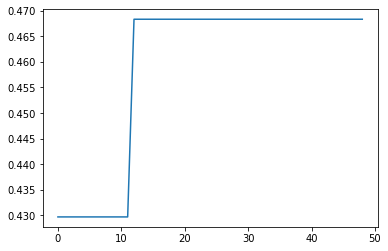

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score as score

y_pred = preds['rslt'].copy()
y_pred[y_pred=='H'] = 1
y_pred[y_pred=='D'] = 0
y_pred[y_pred=='A'] = -1
y_pred = y_pred.astype('int')
X_combined = preds.drop(['xHG', 'xAG', 'FTHG', 'FTAG', 'gd_mdl', 'rslt', 'bookies','model'], axis=1)
#linReg 0.428
#lasso 0.427
#ridge 0.429

# create results vector
y_preds_act = preds_test['rslt'].copy()
y_preds_act[y_preds_act=='H'] = 1
y_preds_act[y_preds_act=='D'] = 0
y_preds_act[y_preds_act=='A'] = -1
y_preds_act = y_preds_act.astype('int')

# create data for prediction
X_comb_test = preds_test.drop(['xHG', 'xAG', 'FTHG', 'FTAG', 'gd_mdl', 'rslt', 'bookies','model'], axis=1)
#y_comb_test = combined_model.predict(X_comb_test)

# create bookie results vector
book_test = preds_test['bookies'].copy()
book_test[book_test=='H'] = 1
book_test[book_test=='D'] = 0
book_test[book_test=='A'] = -1
book_test = book_test.astype('int')

testLoss = []
for n in range(1, 50):
    combined_model = GradientBoostingClassifier(n_estimators=n, learning_rate=0.05,
    max_depth=1).fit(X_combined, y_pred)
    y_comb_test = combined_model.predict(X_comb_test)
    testLoss.append(score(y_preds_act, y_comb_test))
    
plt.subplot()
#plt.plot(range(1, 50), combined_model.train_score_, range(1, 50),
plt.plot(testLoss)

print('Combined model', MSE(y_preds_act, y_comb_test))
print('Bookies', score(y_preds_act, book_test))

print('Combined model', sum(y_preds_act==y_comb_test)/len(y_preds_act))
print('Bookies', sum(book_test==y_preds_act)/len(y_preds_act))

,xHG,xAG,Hp,Dp,Ap,FTHG,FTAG,HomePred,DrawPred,AwayPred,...,GD_D_Pred,GD_A_Pred,rslt,gd_mdl,bookies,model,combA,combD,combH,comb_mod
1552,1.411885,0.982334,0.581395,0.261780,0.183824,NaN,NaN,0.468912,0.269055,0.262030,...,0.041993,0.067173,D,H,H,H,0.166999,0.240127,0.592874,H
1553,1.629814,0.999741,0.632911,0.215054,0.176678,NaN,NaN,0.520902,0.247077,0.232013,...,0.026322,0.036510,D,H,H,H,0.151394,0.213878,0.634728,H
1554,1.378749,1.281018,0.497512,0.279330,0.248139,NaN,NaN,0.392621,0.260077,0.347300,...,0.054011,0.231327,D,H,H,H,0.274474,0.340026,0.385500,H
1555,1.621716,1.098775,0.546448,0.281690,0.198020,NaN,NaN,0.495238,0.247019,0.257735,...,0.058553,0.370584,D,H,H,H,0.179090,0.264594,0.556316,H
1556,1.282805,0.968835,0.534759,0.280112,0.209205,NaN,NaN,0.436546,0.282708,0.280745,...,0.045698,0.093107,D,H,H,H,0.184987,0.273307,0.541706,H


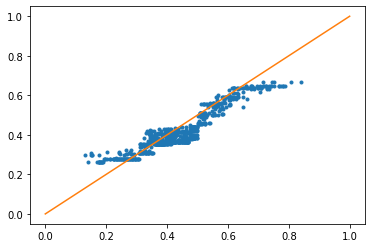

In [12]:
y_comb_prob = combined_model.predict_proba(X_comb_test)
fig, ax1 = plt.subplots(1, 1)
plt.plot(preds_test['Hp'], y_comb_prob[:, 2], '.')
ax1.plot([0, 1], [0, 1])
preds_test[['combA', 'combD', 'combH']] = y_comb_prob

y_comb_rslt = pd.DataFrame(index=preds_test.index)
y_comb_rslt['output'] = y_comb_test
y_comb_rslt['result'] = "D"
y_comb_rslt.loc[y_comb_rslt['output']==1, 'result'] = 'H'
y_comb_rslt.loc[y_comb_rslt['output']==-1, 'result'] = 'A'
preds_test['comb_mod'] = y_comb_rslt['result']
preds_test.head()

1232


<AxesSubplot:xlabel='Ap'>

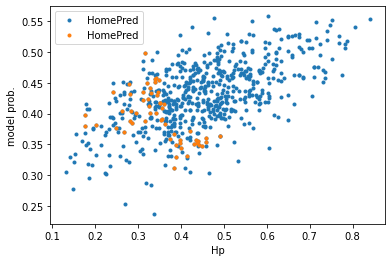

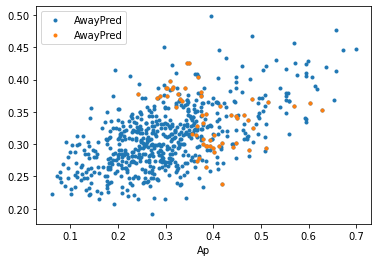

In [13]:
# filter to model true and bookies not true
modTrue = preds_test.loc[(preds_test['rslt']==preds_test['model'])&(preds_test['rslt']!=preds_test['bookies']), :]
print(modTrue.size)
ax1 = preds_test.plot(x='Hp', y='HomePred', style='.', ylabel='model prob.')
modTrue.plot(x='Hp', y='HomePred', style='.', ax=ax1)
ax2 = preds_test.plot(x='Ap', y='AwayPred', style='.')
modTrue.plot(x='Ap', y='AwayPred', style='.', ax=ax2)

<AxesSubplot:xlabel='Ap'>

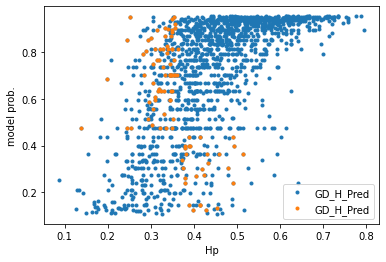

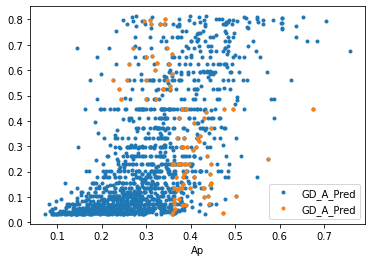

In [14]:
# filter to model true and bookies not true
modTrue = preds.loc[(preds['rslt']==preds['gd_mdl'])&(preds['rslt']!=preds['bookies']), :]
ax1 = preds.plot(x='Hp', y='GD_H_Pred', style='.', ylabel='model prob.')
modTrue.plot(x='Hp', y='GD_H_Pred', style='.', ax=ax1)
ax2 = preds.plot(x='Ap', y='GD_A_Pred', style='.')
modTrue.plot(x='Ap', y='GD_A_Pred', style='.', ax=ax2)

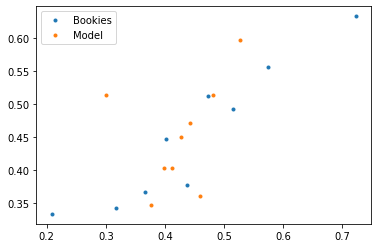

In [15]:
# model accuracy vs. bin
binPlot = preds_test.copy()

def binPlotData (data, colLabel, nBins):
    
    data['bin'] = pd.qcut(data[colLabel], nBins, duplicates='drop')
    data['H_pred_correct'] = 0;
    data.loc[data['rslt']==data['model'], 'H_pred_correct'] = 1

    binList = sorted(data['bin'].unique())
    binVals = np.empty([nBins, 1])
    winPer = np.empty([nBins, 1])
    for i, b in enumerate(binList):
        members = data.loc[data['bin']==b, 'H_pred_correct']
        binVals[i] = b.mid
        winPer[i] = (members==1).sum()/len(members)
        #print(b.mid, sum(GD_DF.loc[(GD_DF['bin']==b)&(GD_DF['Hwin']==1), 'Hwin']))
    return binVals, winPer

#binPlotModelVals, binPlotModelPer = binPlotData(binPlot, 'GD_H_Pred', 9)
binPlotModelVals, binPlotModelPer = binPlotData(binPlot, 'HomePred', 9)
binPlotBookiesVals, binPlotBookiesPer = binPlotData(binPlot, 'Hp', 9)    
    
fig, binnedAx = plt.subplots()
binnedAx.plot(binPlotBookiesVals, binPlotBookiesPer, '.')
binnedAx.plot(binPlotModelVals, binPlotModelPer, '.')
binnedAx.legend(['Bookies', 'Model'])

<AxesSubplot:xlabel='Ap'>

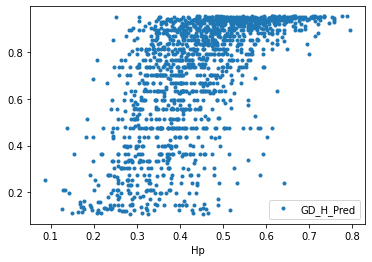

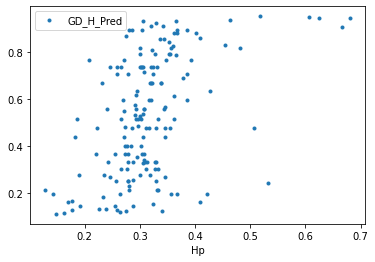

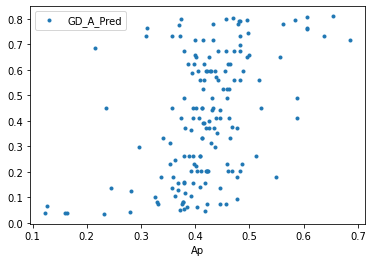

In [16]:
modFalse = preds.loc[(preds['rslt']!=preds['model'])&(preds['rslt']==preds['bookies']), :]
preds.plot(x='Hp', y='GD_H_Pred', style='.')
modFalse.plot(x='Hp', y='GD_H_Pred', style='.')
modFalse.plot(x='Ap', y='GD_A_Pred', style='.')

<AxesSubplot:xlabel='HomePred'>

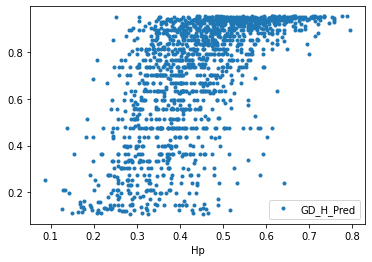

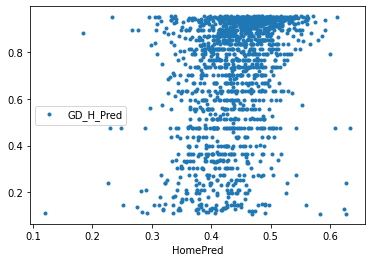

In [17]:
#preds.plot(x='HomePred', y='AwayPred', style='.')

preds.plot(x='Hp', y='GD_H_Pred', style='.')
preds.plot(x='HomePred', y='GD_H_Pred', style='.')
#preds['Hp'].hist()
#preds['GD_H_Pred'].hist()

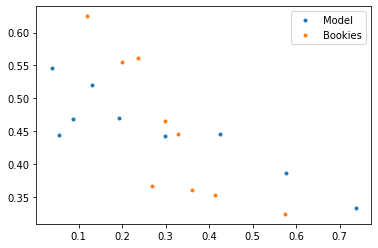

In [18]:
binPlotModelVals, binPlotModelPer = binPlotData(binPlot, 'GD_A_Pred', 9)
binPlotBookiesVals, binPlotBookiesPer = binPlotData(binPlot, 'Ap', 9)    
    
fig, binnedAx = plt.subplots()
binnedAx.plot(binPlotModelVals, binPlotModelPer, '.')
binnedAx.plot(binPlotBookiesVals, binPlotBookiesPer, '.')
binnedAx.legend(['Model', 'Bookies'])

<BarContainer object of 29 artists>

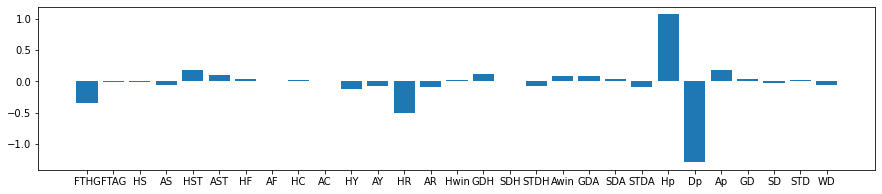

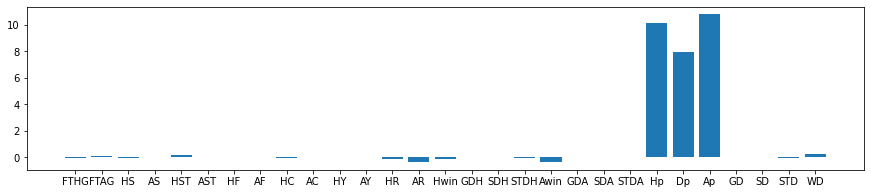

In [19]:
#print(X_train.columns, HG_ridge.coef_)
plt.subplots(figsize=(15, 3))
plt.bar(X_train.columns, HG_ridge.coef_)
plt.subplots(figsize=(15, 3))
plt.bar(X_train.columns, AG_clf.coef_)